In [1]:
from isaac_victor_envs.utils import get_assets_dir
from isaac_victor_envs.tasks.allegro import AllegroScrewdriverTurningEnv
# from isaac_victor_envs.tasks.allegro_ros import RosAllegroValveTurningEnv

import numpy as np
import pickle
from tqdm.notebook import tqdm

import scipy
import torch
import time
import copy
import yaml
import pathlib
from functools import partial
import sys

import pytorch_volumetric as pv
import pytorch_kinematics as pk
import pytorch_kinematics.transforms as tf
from torch.func import vmap, jacrev, hessian, jacfwd
# import pytorch3d.transforms as tf

import matplotlib.pyplot as plt
from ccai.utils.allegro_utils import *
# from allegro_valve_roll import AllegroValveTurning, AllegroContactProblem, PositionControlConstrainedSVGDMPC, \
#    add_trajectories, add_trajectories_hardware

from ccai.allegro_contact import AllegroManipulationProblem, PositionControlConstrainedSVGDMPC, add_trajectories, \
    add_trajectories_hardware
from ccai.allegro_screwdriver_problem_diffusion import AllegroScrewdriverDiff
from scipy.spatial.transform import Rotation as R

# from ccai.mpc.ipopt import IpoptMPC
# from ccai.problem import IpoptProblem
from ccai.models.trajectory_samplers import TrajectorySampler

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

Importing module 'gym_38' (/home/abhinav/Downloads/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/abhinav/Downloads/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 2.4.0+cu121
Device count 1
/home/abhinav/Downloads/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/abhinav/.cache/torch_extensions/py38_cu121 as PyTorch extensions root...
Emitting ninja build file /home/abhinav/.cache/torch_extensions/py38_cu121/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
obj_dof = 3
# config = yaml.safe_load(pathlib.Path(f'../examples/config/{sys.argv[1]}.yaml').read_text())
config = yaml.safe_load(pathlib.Path(f'../examples/config/allegro_screwdriver_csvto_only.yaml').read_text())
config['visualize'] = False

if config['mode'] == 'hardware':
    env = RosAllegroValveTurningEnv(1, control_mode='joint_impedance',
                                    use_cartesian_controller=False,
                                    viewer=True,
                                    steps_per_action=60,
                                    friction_coefficient=1.0,
                                    device=config['sim_device'],
                                    valve=config['object_type'],
                                    video_save_path=img_save_dir,
                                    joint_stiffness=config['kp'],
                                    fingers=config['fingers'],
                                    )
else:
    if not config['visualize']:
        img_save_dir = None

    env = AllegroScrewdriverTurningEnv(1, control_mode='joint_impedance',
                                        use_cartesian_controller=False,
                                        viewer=config['visualize'],
                                        steps_per_action=60,
                                        friction_coefficient=config['friction_coefficient'] * 1.05,
                                        # friction_coefficient=1.0,  # DEBUG ONLY, set the friction very high
                                        device=config['sim_device'],
                                        video_save_path=img_save_dir,
                                        joint_stiffness=config['kp'],
                                        fingers=config['fingers'],
                                        )

sim, gym, viewer = env.get_sim()

state = env.get_state()
# try:
#     while True:
#         start = env.get_state()['q'][:, :-1]
#         env.step(start)
#         print('waiting for you to finish camera adjustment, ctrl-c when done')
#         time.sleep(0.1)
# except KeyboardInterrupt:
#     pass

sim_env = None
ros_copy_node = None
if config['mode'] == 'hardware':
    sim_env = env
    from hardware.hardware_env import HardwareEnv

    env = HardwareEnv(sim_env.default_dof_pos[:, :16], finger_list=['index', 'thumb'], kp=config['kp'])
    env.world_trans = sim_env.world_trans
    env.joint_stiffness = sim_env.joint_stiffness
    env.device = sim_env.device
    env.valve_pose = sim_env.valve_pose
elif config['mode'] == 'hardware_copy':
    from hardware.hardware_env import RosNode

    ros_copy_node = RosNode()

results = {}

# set up the kinematic chain
asset = f'{get_assets_dir()}/xela_models/allegro_hand_right.urdf'
ee_names = {
    'index': 'allegro_hand_hitosashi_finger_finger_0_aftc_base_link',
    'middle': 'allegro_hand_naka_finger_finger_1_aftc_base_link',
    'ring': 'allegro_hand_kusuri_finger_finger_2_aftc_base_link',
    'thumb': 'allegro_hand_oya_finger_3_aftc_base_link',
}
config['ee_names'] = ee_names
config['obj_dof'] = 3

screwdriver_asset = f'{get_assets_dir()}/screwdriver/screwdriver.urdf'

chain = pk.build_chain_from_urdf(open(asset).read())
screwdriver_chain = pk.build_chain_from_urdf(open(screwdriver_asset).read())
frame_indices = [chain.frame_to_idx[ee_names[finger]] for finger in config['fingers']]  # combined chain
frame_indices = torch.tensor(frame_indices)
state2ee_pos = partial(state2ee_pos, fingers=config['fingers'], chain=chain, frame_indices=frame_indices,
                        world_trans=env.world_trans)

forward_kinematics = partial(chain.forward_kinematics,
                                frame_indices=frame_indices)  # full_to= _partial_state = partial(full_to_partial_state, fingers=config['fingers'])
partial_to_full_state = partial(partial_to_full_state, fingers=config['fingers'])

controller = 'csvgd'
goal = - 0.5 * torch.tensor([0, 0, np.pi])
# set up params
params = config.copy()
params.pop('controllers')
params.update(config['controllers'][controller])
params['controller'] = controller
params['valve_goal'] = goal.to(device=params['device'])
params['chain'] = chain.to(device=params['device'])
object_location = torch.tensor([0, 0, 1.205]).to(
    params['device'])  # TODO: confirm if this is the correct location
params['object_location'] = object_location

num_fingers = len(params['fingers'])
state = env.get_state()
start = state['q'].reshape(4 * num_fingers + 4).to(device=params['device'])
if 'csvgd' in params['controller']:
    # index finger is used for stability
    if 'index' in params['fingers']:
        fingers = params['fingers']
    else:
        fingers = ['index'] + params['fingers']

pregrasp_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    regrasp_fingers=fingers,
    contact_fingers=[],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
)
# finger gate index
index_regrasp_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    regrasp_fingers=['index'],
    contact_fingers=['middle', 'thumb'],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
    default_dof_pos=env.default_dof_pos[:, :16]
)
thumb_and_middle_regrasp_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    contact_fingers=['index'],
    regrasp_fingers=['middle', 'thumb'],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
    default_dof_pos=env.default_dof_pos[:, :16]
)
turn_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    contact_fingers=['index', 'middle', 'thumb'],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
    default_dof_pos=env.default_dof_pos[:, :16]
)
contact_mode_dict = {0: 'pregrasp', 2: 'index', 1: 'thumb_middle', 3: 'turn'}
t = params['T']
# with open(data_path / f'constraint_violations.p', 'wb') as f:
#     pickle.dump(constraint_violations_all, f)


Not connected to PVD
Physics Engine: PhysX
Physics Device: cpu
GPU Pipeline: disabled
Using VHACD cache directory '/home/abhinav/.isaacgym/vhacd'
Found existing convex decomposition for mesh '/home/abhinav/Documents/git_packages/isaacgym-arm-envs/isaac_victor_envs/assets/xela_models/mesh/allegro/base_ns.stl'
Found existing convex decomposition for mesh '/home/abhinav/Documents/git_packages/isaacgym-arm-envs/isaac_victor_envs/assets/xela_models/mesh/allegro/link_1.0.stl'
Found existing convex decomposition for mesh '/home/abhinav/Documents/git_packages/isaacgym-arm-envs/isaac_victor_envs/assets/xela_models/mesh/ft_c.stl'


/home/abhinav/Documents/git_packages/pytorch_volumetric/src/pytorch_volumetric/sdf.py:1137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache = torch.load(dbpath)


In [3]:
def calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits, proj_diff=True):
    if not torch.is_tensor(to_eval):
        to_eval = torch.tensor(to_eval).to(device=params['device'])
    else:
        to_eval = to_eval.to(device=params['device'])
    if c_state == 'pregrasp':
        # Call _con_eq and _con_ineq to get constraint violation
        prob = pregrasp_problem
        inds = torch.arange(27)

    elif c_state == 'index':
        prob = index_regrasp_problem
        # Need to rearrange (index, middle, thumb)
        if plans_or_inits == 'plans':
            inds = torch.cat((torch.arange(27), torch.arange(30, 36)))
        else:
            inds = torch.arange(33)

    elif c_state == 'thumb_middle':
        prob = thumb_and_middle_regrasp_problem
        inds = torch.arange(30)

    elif c_state == 'turn':
        prob = turn_problem
        inds = torch.arange(36)

    prob._preprocess(to_eval, projected_diffusion=proj_diff)
    g, _, _ = prob._con_eq(to_eval[..., inds], compute_grads=False, compute_hess=False, verbose=True, projected_diffusion=proj_diff)
    h, _, _ = prob._con_ineq(to_eval[..., inds], compute_grads=False, compute_hess=False, verbose=True, projected_diffusion=proj_diff)
    if g is not None:
        g = g.cpu()
    if h is not None:
        h = h.cpu()

    info = {'g': g, 'h': h, 'c_state': c_state}
    info_list.append(info)
    return info_list

def gen_constraint_data(plans_or_inits, constraint_violations, path, traj_data=[None]*10):
    for trial in tqdm(range(1, 11)):
        info_list = []
        try:
            if traj_data[trial-1] is None:
                try:
                    with open(path + f'/trial_{trial}/traj_data.p', 'rb') as f:
                        data = pickle.load(f)
                except:
                    continue
        except:
            continue
        else:
            data = traj_data[trial-1]
        if plans_or_inits == 'plans':
            data[t]['plans'] = torch.tensor(data[t]['plans']).to(device=params['device'])
            loop_range = data[t]['plans'].shape[0]
        elif plans_or_inits == 'optimizer_paths':
            loop_range = len(data[t]['optimizer_paths'])
        elif plans_or_inits == 'planned_inits':
            loop_range = len(data[t]['planned_inits'])
        else:
            loop_range = len(data[t]['inits'])
        for i in (range(loop_range)):
            c_state = contact_mode_dict[data[t]['contact_state'][i].sum().item()]
            to_eval = data[t][plans_or_inits][i]
            # if plans_or_inits == 'optimizer_paths':
            #     to_eval = to_eval[0].flatten(0, 1)
            # info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
            if plans_or_inits in {'plans', 'inits', 'traj'}:
                info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits, proj_diff=False)
            else:
                to_eval = to_eval[0]
                all_infos = []
                for csvto_tstep in (range(data[t]['optimizer_paths'][i][0].shape[0])):
                    all_infos = calc_info(c_state, to_eval[csvto_tstep], all_infos, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits, proj_diff=False)
                info_list.append(all_infos)
        constraint_violations.append(info_list)

In [219]:
def get_traj(name):
    path = f'/home/abhinav/Documents/ccai/data/experiments/{name}/csvgd'

    all_data = []
    all_x = []
    # all_d2goal = []
    all_traj_data = []
    for trial_num in range(1, 11):
        # print(path + f'/trial_{trial_num}/trajectory.npz')
        # if 'rand' in name or 'proj' in name or 'diff' in name:
        try:
            with open(path + f'/trial_{trial_num}/trajectory.pkl', 'rb') as data:
                d = pickle.load(data)
                traj = np.stack((d[:-1]), axis=0)
                # end = d[-1].reshape(1, -1)
                # end = np.concatenate((end, np.zeros((1, 21))), axis=1)
                # traj = np.concatenate((traj, end), axis=0)
            # else:
            #     d = np.load(path + f'/trial_{trial_num}/trajectory.npz')
            #     end_state = d['x'] 
            with open(path + f'/trial_{trial_num}/traj_data.p', 'rb') as f:
                traj_data = pickle.load(f)
                for key in traj_data.keys():
                    if torch.is_tensor(traj_data[key]):
                        traj_data[key] = traj_data[key].cpu().numpy()
                # all_d2goal.append(d2goal)
                # if 'rand' not in name and 'proj' not in name and 'diff' not in name::
                #     traj = traj_data[t]['plans'][:, 0]

                    # end = np.concatenate((end_state, np.zeros((1, 21))), axis=1)
                    # traj = np.concatenate((traj, end), axis=0)
                traj_data[t]['traj'] = np.expand_dims(traj, axis=1)
                all_traj_data.append(traj_data)  
                all_data.append(traj_data)
            'opened'
        except:
            continue
            
    constraint_violations_all = {
        # 'optimizer_paths': [],
        'traj': [],
        # 'inits': [],
        # 'plans': [],

    }
    # for plans_or_inits in constraint_violations_all.keys():
    #     if plans_or_inits == 'traj':
    #         gen_constraint_data(plans_or_inits, constraint_violations_all[plans_or_inits], path, traj_data=all_traj_data)
    #     else:
    #         gen_constraint_data(plans_or_inits, constraint_violations_all[plans_or_inits], path)

    # Take the list of dicts and turn it into a dict of lists
    all_data = {k: [d[k] for d in all_data] for k in all_data[0]}
    all_data['violation'] = constraint_violations_all

    return all_x, all_data#, all_d2goal

In [335]:
dofs = {
    'roll': -3,
    'pitch': -2,
    'yaw': -1
}
conf = scipy.stats.norm.ppf(.95) 

def gen_plot_screwdriver_angle(data, keys, plans_or_inits, dof_to_plot=['yaw'], stat='mean', label_dict=None):
    # data[key][t][trial_ind][plans_or_inits]
    fig, ax = plt.subplots(1, len(dof_to_plot), figsize=(len(dof_to_plot)*17/3, 4))
    if len(dof_to_plot) == 1:
        ax = [ax]
    for key in keys:
        traj_all = []
        to_continue = False
        for trial_ind in range(10):
            try:
                if plans_or_inits == 'traj':
                    traj = data[key][t][trial_ind][plans_or_inits].reshape(-1, 36)[:, :15]
                    traj_all.append(traj)
                else:
                    if len(data[key])-1 <= trial_ind:
                        to_continue = True
                        continue
                    # traj = torch.stack([i[..., :15] for i in data[key][trial_ind+1][plans_or_inits]], axis=1).flatten(1, 2)
                    # traj = traj.cpu()
                    # for i in range(traj.shape[0]):
                    #     traj_all.append(traj[i])
                    traj_all.append(data[key][trial_ind+1][plans_or_inits].cpu().numpy()[..., :15])
            except:
                continue
        # Pad to length 112 with the last value
        if to_continue:
            continue
        lengths = [len(x) for x in traj_all]
        num_contact_modes = [x/t for x in lengths]
        max_len = max(lengths)
        for i in range(len(traj_all)):
            traj_all[i] = np.concatenate((traj_all[i], np.tile(traj_all[i][-1], (max_len - len(traj_all[i]), 1))), axis=0)
        traj_all = np.stack(traj_all, axis=0)
        # Subtract the initial value
        start_ind = 0
        num_to_plot = 48
        traj_all = traj_all - traj_all[:, start_ind:start_ind+1, :]
        traj_all = traj_all[traj_all[:, start_ind + num_to_plot-1, -1] < 0]
        print(key, np.mean(num_contact_modes), traj_all[:, start_ind + num_to_plot-1, -1].mean(), traj_all[:, start_ind + num_to_plot-1, -1])
        print()
        if stat == 'mean':
            traj_all_mean = traj_all.mean(axis=0)[:, [dofs[d] for d in dof_to_plot]]
            traj_all_std = traj_all.std(axis=0)[:, [dofs[d] for d in dof_to_plot]]
        elif stat == 'median':
            traj_all_median = np.median(traj_all, axis=0)[:, [dofs[d] for d in dof_to_plot]]
        for i, dof in enumerate(dof_to_plot):
            if label_dict is not None:
                label = label_dict[key]
            if stat == 'mean':
                # print(traj_all[:, :12, -1])
                ax[i].plot(traj_all_mean[:, i], label=label)
                # calculate 95% confidence interval
                bound_offset = traj_all_std[:, i] * conf / np.sqrt(traj_all.shape[0])
                ax[i].fill_between(np.arange(traj_all_mean.shape[0]), traj_all_mean[:, i] - bound_offset, traj_all_mean[:, i] + bound_offset, alpha=0.5)
            elif stat == 'median':
                ax[i].plot(traj_all_median[:, i], label=label)
            elif stat == 'all':
                for traj_ind in range(traj_all.shape[0]):
                    # print(traj_all.shape)
                    ax[i].plot(traj_all[traj_ind, start_ind:start_ind + num_to_plot, dofs[dof]], label=traj_ind)
    for i, dof in enumerate(dof_to_plot):
        ax[i].legend()
        ax[i].set_xlabel('Timestep')
        ax[i].set_ylabel(f'Screwdriver {dof} Angle (rad)'.title())
        # Grid lines
        ax[i].grid(True)
        #y axis numbers on right side as well
        ax[i].yaxis.tick_right()
        # Title dof
        ax[i].set_title(f'{dof} Angle 95% Confidence Interval'.title() + f' (n={traj_all.shape[0]})')
    plt.show()

In [329]:
data_exec = {}
t = params['T']

# with open('./saved_eval.pkl', 'rb') as f:
#     data = pickle.load(f)
# for key, name in [('rand_init_csvto', 'allegro_screwdriver_random_init_no_guidance_actual_random'), ('diff_init_csvto', 'allegro_screwdriver_diffusion_init_no_guidance_retry'), ('proj_diff_init_csvto', 'allegro_screwdriver_projected_diffusion_init_no_guidance')]:
# for key, name in [('proj_diff_init_csvto_presampled', 'allegro_screwdriver_projected_diffusion_init_no_guidance_pre_sampled'), ('proj_diff_init_csvto_presampled_guided', 'allegro_screwdriver_projected_diffusion_init_guidance_pre_sampled'), ('proj_diff_init_csvto_pre_sampled_high_noise', 'allegro_screwdriver_projected_diffusion_init_no_guidance_pre_sampled_high_sample_noise')]:
# for key, name in [('proj_diff_init_csvto_presampled_guided_high_noise', 'allegro_screwdriver_projected_diffusion_init_guidance_pre_sampled_high_sample_noise'), ('diff_init_csvto_presampled_high_noise', 'allegro_screwdriver_diffusion_init_no_guidance_pre_sampled_high_sample_noise')]:
    
# for key, name in [('heuristic x1000', 'allegro_screwdriver_diffusion_planned_initialization_redo'), ('heuristic x100', 'allegro_screwdriver_diffusion_planned_initialization_medium_heuristic'),
#                   ('heuristic x10', 'allegro_screwdriver_diffusion_planned_initialization_low_heuristic'), ('heuristic x1', 'allegro_screwdriver_diffusion_planned_initialization_lower_heuristic'),
for key, name in [
    # ('heuristic x1', 'allegro_screwdriver_diffusion_planned_initialization_lower_heuristic_bad_contact_map'),
    #               ('heuristic x10', 'allegro_screwdriver_diffusion_planned_initialization_low_heuristic_bad_contact_map'),
    #               ('heuristic x100', 'allegro_screwdriver_diffusion_planned_initialization_medium_heuristic_bad_contact_map'),
                #   ('heuristic x1000 partial', 'allegro_screwdriver_diffusion_planned_initialization_partial_constraint_eval'),
                # ('heuristic x1000 full', 'allegro_screwdriver_diffusion_planned_initialization_full_constraint_eval'),
                # ('prior', 'allegro_screwdriver_diffusion_planned_initialization_3_turn'),
                # ('CSVTO', 'allegro_screwdriver_csvto_only_eps_.01_.5_damping_pi_6'),
                # ('Diffusion', 'allegro_screwdriver_diff_only_sine_cosine_eps_.015_2.5_damping_pi_6'),
                # ('Diffusion sc', 'allegro_screwdriver_diff_only_sine_cosine'),
                # ('CSVTO + Diffusion', 'allegro_screwdriver_csvto_diff_sine_cosine_eps_.015_.5_damping_pi_6'),
                # ('CSVTO + Diffusion sc', 'allegro_screwdriver_csvto_diff_sine_cosine'),
                # ('CSVTO + Diffusion + A* 1.7', 'allegro_screwdriver_csvto_diff_planned_contact_sine_cosine_1.7_eps_.015_2.5_damping_pi_6'),
                # ('CSVTO + Diffusion + A* 2', 'allegro_screwdriver_csvto_diff_planned_contact_sine_cosine_2_eps_.015_2.5_damping_pi_6'),
                # ('CSVTO + Diffusion + A* sc', 'allegro_screwdriver_csvto_diff_planned_contact_sine_cosine'),
                # ('CSVTO + Diffusion + A* + replan', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_sine_cosine_eps_.015_2.5_damping_pi_6'),
                # ('CSVTO + Diffusion + A* + replan less', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_sine_cosine_eps_.01_2.5_damping'),
                # ('CSVTO + Diffusion + A* + replan pi 4', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_sine_cosine_eps_.01_2.5_damping_no_discount'),
                # ('CSVTO + Diffusion + A* + replan higher', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_sine_cosine_eps_.01_2.5_damping_receding_goal'),
                # ('CSVTO + Diffusion + A* + replan sc', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_sine_cosine'),
                # ('CSVTO + Diffusion + A* + replan fg', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_sine_cosine_fixed_goal'),
                # ('CSVTO + Diffusion + A* + replan max likelihood 16', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_single_particle_16_sine_cosine_eps_.015_2.5_damping_pi_6'),
                # ('CSVTO + Diffusion + A* + replan max likelihood', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_max_likelihood_sine_cosine_eps_.015_.5_damping_pi_6'),
                # ('CSVTO + Diffusion + A* + replan no unc. propagation', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_single_particle_single_sample_sine_cosine_eps_.015_.5_damping_pi_6'),
                # ('CSVTO + Diffusion + A* + replan no prop sc', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_single_particle_sine_cosine'),
                # ('CSVTO + Diffusion + A* + replan no prop ss sc', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_single_particle_single_sample_sine_cosine'),
                # ('CSVTO + A* + replan sc', 'allegro_screwdriver_csvto_diff_planned_replanned_contact_sine_cosine_no_diff_init')
                # ('CSVTO low friction', 'allegro_screwdriver_csvto_only_low_friction'),
                # ('CSVTO 2 friction .5 damping', 'allegro_screwdriver_csvto_only_4_friction_.5_damping')
                # ('CSVTO high friction med damping', 'allegro_screwdriver_csvto_only_high_friction_med_damping')
                # ('CSVTO eps .01', 'allegro_screwdriver_csvto_only_4_friction_.5_damping'),
                # ('CSVTO eps .01 d .5', 'allegro_screwdriver_csvto_only_eps_.01_.5_damping'),
                # ('CSVTO eps .01 d 1', 'allegro_screwdriver_csvto_only_eps_.01_1_damping'),
                
                # ('CSVTO + Diffusion hardware', 'allegro_screwdriver_csvto_diff_hardware.08.31.24:11:20:58'),
                # ('CSVTO + Diffusion + A* hardware', 'allegro_screwdriver_csvto_diff_planned_replanned_hardware.08.31.24:01:00:44')
                ('CSVTO + Diffusion + A* hardware', 'real_world_full_method_high_csvto_budget_acc'),
                ('CSVTO + Diffusion hardware', 'real_world_csvto_diff_high_csvto_budget_acc'),
                # ('CSVTO + Diffusion no reg', 'allegro_screwdriver_csvto_diff_hardware.09.02.24:05:56:31')
                ('CSVTO + Diffusion no reg', 'allegro_screwdriver_csvto_diff_hardware.09.02.24:07:14:24')
                ]:
    
# for key, name in [('pre-planned', 'allegro_screwdriver_diffusion_init_pre_sampled_guided')]:
    print(key)
    data_exec[key] = {}
    all_x, all_data = get_traj(name)
    # data[key]['x'] = {
    #     'raw': all_x,
    #     'mean': np.mean(all_x, axis=0),
    #     'std': np.std(all_x, axis=0),
    # }
    data_exec[key] = {**data_exec[key], **all_data}
    # data[key]['d2goal'] = {
    #     'raw': all_d2goal,
    #     'mean': np.mean(all_d2goal, axis=0),
    #     'std': np.std(all_d2goal, axis=0),
    # }

# with open('./saved_eval.pkl', 'wb') as f:
#     pickle.dump(data, f)

CSVTO + Diffusion + A* hardware
CSVTO + Diffusion hardware
CSVTO + Diffusion no reg


CSVTO + Diffusion + A* hardware 4.0 -0.8452314 [-0.7782687  -0.7007905  -0.44393545 -1.1784744  -1.0985763  -0.68679607
 -1.029778  ]

CSVTO + Diffusion hardware 4.0 -0.5910455 [-0.5812189  -0.56398326 -0.35311055 -0.8217369  -0.53532714 -0.5676292
 -0.7143123 ]



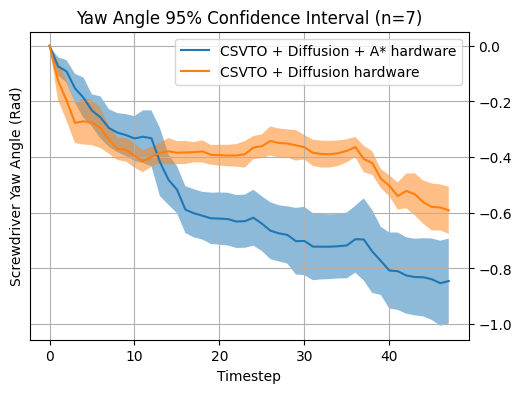

CSVTO + Diffusion hardware 4.0 -0.5910455 [-0.5812189  -0.56398326 -0.35311055 -0.8217369  -0.53532714 -0.5676292
 -0.7143123 ]



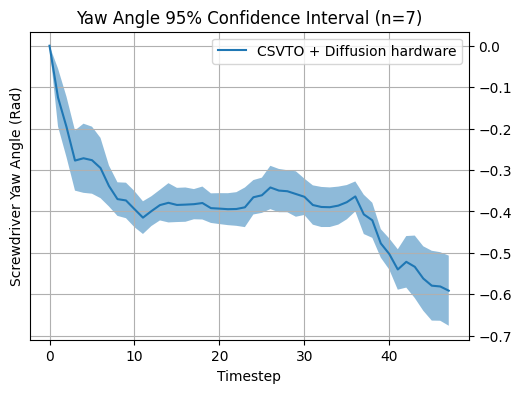

In [336]:
# keys_exec = ['fixed', 'planned w/ replanning', 'planned no replanning']
# keys_exec = ['CSVTO', 'Diffusion', 'Diffusion sc', 'CSVTO + Diffusion', 'CSVTO + Diffusion sc']
# keys_exec = ['CSVTO', 'Diffusion sc', 'CSVTO + Diffusion sc', 'CSVTO + Diffusion + A*', 'CSVTO + Diffusion + A* sc']

# keys_exec = ['CSVTO', 'CSVTO + Diffusion sc', 'CSVTO + Diffusion + A* sc', 'CSVTO + Diffusion + A* + replan sc']
t = params['T']
stat = 'mean'
# dofs_to_plot = ['roll', 'pitch', 'yaw']
dofs_to_plot = ['yaw']

keys_exec = [
    # 'CSVTO',
    # 'Diffusion'
    # 'CSVTO + Diffusion',
    # 'CSVTO + Diffusion + A* 1.7',
    # 'CSVTO + Diffusion + A* 2',
    #  'CSVTO + Diffusion + A* + replan',
    'CSVTO + Diffusion + A* hardware',    
    'CSVTO + Diffusion hardware'    
              ]
gen_plot_screwdriver_angle(data_exec, keys_exec, 'traj', dof_to_plot=dofs_to_plot, stat=stat, label_dict={
    'CSVTO + Diffusion + A* hardware': 'CSVTO + Diffusion + A* hardware',
    'CSVTO + Diffusion hardware': 'CSVTO + Diffusion hardware',

    # 'CSVTO': 'CSVTO-No Contact Planning',
    # 'Diffusion': 'Diffusion',
    # 'CSVTO + Diffusion': 'DUCATS-No Contact Planning',
    # 'CSVTO + Diffusion + A* 1.7': 'DUCATS-No Contact Replanning',
    # 'CSVTO + Diffusion + A* 2': 'DUCATS-No replanning 2',
    # 'CSVTO + Diffusion + A* + replan': 'DUCATS',
})

keys_exec = [
    # 'CSVTO',
    # 'Diffusion'
    # 'CSVTO + Diffusion',
    # 'CSVTO + Diffusion + A* 1.7',
    # 'CSVTO + Diffusion + A* 2',
    #  'CSVTO + Diffusion + A* + replan',
    # 'CSVTO + Diffusion + A* hardware',    
    'CSVTO + Diffusion hardware'    
              ]
gen_plot_screwdriver_angle(data_exec, keys_exec, 'traj', dof_to_plot=dofs_to_plot, stat=stat, label_dict={
    # 'CSVTO + Diffusion + A* hardware': 'CSVTO + Diffusion + A* hardware',
    'CSVTO + Diffusion hardware': 'CSVTO + Diffusion hardware',

    # 'CSVTO': 'CSVTO-No Contact Planning',
    # 'Diffusion': 'Diffusion',
    # 'CSVTO + Diffusion': 'DUCATS-No Contact Planning',
    # 'CSVTO + Diffusion + A* 1.7': 'DUCATS-No Contact Replanning',
    # 'CSVTO + Diffusion + A* 2': 'DUCATS-No replanning 2',
    # 'CSVTO + Diffusion + A* + replan': 'DUCATS',
})
# keys_exec = [
#               'CSVTO + Diffusion + A* + replan no unc. propagation',
#               'CSVTO + Diffusion + A* + replan max likelihood',
#                 # 'CSVTO + Diffusion + A* + replan',
#               ]
# gen_plot_screwdriver_angle(data_exec, keys_exec, 'traj', dof_to_plot=dofs_to_plot, stat=stat, label_dict={
#     # 'CSVTO + Diffusion + A* + replan': 'CSVTO + Diffusion + A*',
#     # 'CSVTO + Diffusion + A* + replan': 'DUCATS',
#     'CSVTO + Diffusion + A* + replan max likelihood': 'DUCATS-Max likelihood',
#     'CSVTO + Diffusion + A* + replan no unc. propagation': 'DUCATS-No uncertainty propagation'
# })


In [307]:
#data_exec[method][T][trial][plans_or_inits][c_i][plan_ind]
trial_ind = 6
# print(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['contact_state'])
# print([np.abs(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['inits'][c_ind][:, :, 27:]).sum(axis=1).sum(axis=1) for c_ind in range(4)])
all_forces = []
all_forces_0 = []
all_forces_1 = []
all_forces_2 = []
all_forces_3 = []
for trial_ind in range(len(data_exec['CSVTO + Diffusion + A* hardware'][12])):
    c_state = [contact_mode_dict[data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['contact_state'][i].sum().item()]  for i in range(len(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['contact_state']))]
    print(c_state)
    plan = data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['plans'][[i for i in range(len(c_state)) if c_state[i] == 'turn'], 0]
    turn_f = (plan[:, -1, 14] - plan[:, 0, 14]).tolist()
    plan_all = data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['plans'][[i for i in range(len(c_state))], 0]
    turn_f_all = (plan_all[:, -1, 14] - plan_all[:, 0, 14]).tolist()

    # turn_f = (sorted(np.abs(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['plans'][:, 0, :, 27:]).sum(axis=1).sum(axis=1))[-2:])
    all_forces += [i for i in turn_f if i < 0]
    if turn_f_all[0] < 0:
        all_forces_0.append(turn_f_all[0])
    if turn_f_all[1] < 0:
        all_forces_1.append(turn_f_all[1])
    if turn_f_all[2] < 0:
        all_forces_2.append(turn_f_all[2])
    if turn_f_all[3] < 0:
        all_forces_3.append(turn_f_all[3])

print(len(all_forces), all_forces)
print(np.mean(all_forces), np.std(all_forces))
print()
print(len(all_forces_0), all_forces_0)
print(np.mean(all_forces_0), np.std(all_forces_0))
print(len(all_forces_1), all_forces_1)
print(np.mean(all_forces_1), np.std(all_forces_1))
print(len(all_forces_2), all_forces_2)
print(np.mean(all_forces_2), np.std(all_forces_2))
print(len(all_forces_3), all_forces_3)
print(np.mean(all_forces_3), np.std(all_forces_3))

['thumb_middle', 'turn', 'thumb_middle', 'turn']
['thumb_middle', 'turn', 'turn', 'index']
['turn', 'turn', 'turn', 'thumb_middle']
['turn', 'turn', 'thumb_middle', 'turn']
['turn', 'turn', 'thumb_middle', 'turn']
['turn', 'turn', 'thumb_middle', 'turn']
['turn', 'thumb_middle', 'turn', 'index']
['thumb_middle', 'turn', 'turn', 'thumb_middle']
19 [-0.3597146272659302, -0.17169922590255737, -0.17195561528205872, -0.35970890522003174, -0.17107045650482178, -0.06741487979888916, -0.3641079068183899, -0.1433979868888855, -0.171197772026062, -0.2636532187461853, -0.17736679315567017, -0.27332890033721924, -0.20740249752998352, -0.2044062316417694, -0.16581952571868896, -0.29264509677886963, -0.2520065903663635, -0.08765542507171631, -0.2828128933906555]
-0.22038760781288147 0.08461581665102055

6 [-0.35970890522003174, -0.3641079068183899, -0.2636532187461853, -0.20740249752998352, -0.29264509677886963, -0.16840200126171112]
-0.27598660439252853 0.0724369057779674
6 [-0.17169922590255737, -

In [323]:
#data_exec[method][T][trial][plans_or_inits][c_i][plan_ind]
trial_ind = 6
# print(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['contact_state'])
# print([np.abs(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['inits'][c_ind][:, :, 27:]).sum(axis=1).sum(axis=1) for c_ind in range(4)])
all_forces = []
all_forces_0 = []
all_forces_1 = []
for trial_ind in range(len(data_exec['CSVTO + Diffusion hardware'][12])):
    c_state = [contact_mode_dict[data_exec['CSVTO + Diffusion hardware'][12][trial_ind]['contact_state'][i].sum().item()]  for i in range(len(data_exec['CSVTO + Diffusion hardware'][12][trial_ind]['contact_state']))]
    print(c_state)
    plan = data_exec['CSVTO + Diffusion hardware'][12][trial_ind]['plans'][[i for i in range(len(c_state)) if c_state[i] == 'turn'], 0]
    turn_f = (plan[:, -1, 14] - plan[:, 0, 14]).tolist()
    # turn_f = (sorted(np.abs(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['plans'][:, 0, :, 27:]).sum(axis=1).sum(axis=1))[-2:])
    all_forces += [i for i in turn_f if i < 0]
    if turn_f[0] < 0:
        all_forces_0.append(turn_f[0])
    if len(turn_f) > 1 and turn_f[1] < 0:
        all_forces_1.append(turn_f[1])
print(len(all_forces), all_forces)
print(np.mean(all_forces), np.std(all_forces))
print()
print(len(all_forces_0), all_forces_0)
print(np.mean(all_forces_0), np.std(all_forces_0))
print(len(all_forces_1), all_forces_1)
print(np.mean(all_forces_1), np.std(all_forces_1))

['turn', 'thumb_middle', 'index', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
['turn', 'index', 'thumb_middle', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
13 [-0.11321920156478882, -0.0903351902961731, -0.2361924648284912, -0.1351611614227295, -0.07187812030315399, -0.25193536281585693, -0.20938043296337128, -0.36103689670562744, -0.18871137499809265, -0.0427108108997345, -0.086823970079422, -0.0261155366897583, -0.02368849515914917]
-0.14132223220971915 0.09783906057225114

6 [-0.11321920156478882, -0.2361924648284912, -0.07187812030315399, -0.20938043296337128, -0.18871137499809265, -0.086823970079422]
-0.15103426078955332 0.06310625321829857
7 [-0.0903351902961731, -0.1351611614227295, -0.25193536281585693, -0.36103689670562744, -0.0427108108997345, -0.0261155366897583, -0.02368849515914917]
-0.132997636284147 0.11922178289102


In [313]:
#data_exec[method][T][trial][plans_or_inits][c_i][plan_ind]
trial_ind = 6
# print(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['contact_state'])
# print([np.abs(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['inits'][c_ind][:, :, 27:]).sum(axis=1).sum(axis=1) for c_ind in range(4)])
all_forces = []
all_forces_0 = []
all_forces_1 = []
for trial_ind in range(len(data_exec['CSVTO + Diffusion hardware'][12])):
    c_state = [contact_mode_dict[data_exec['CSVTO + Diffusion hardware'][12][trial_ind]['contact_state'][i].sum().item()]  for i in range(len(data_exec['CSVTO + Diffusion hardware'][12][trial_ind]['contact_state']))]
    print(c_state)
    plan = data_exec['CSVTO + Diffusion hardware'][12][trial_ind]['plans'][[i for i in range(len(c_state)) if c_state[i] == 'turn'], 0]
    turn_f = (plan[:, -1, 14] - plan[:, 0, 14]).tolist()
    # turn_f = (sorted(np.abs(data_exec['CSVTO + Diffusion + A* hardware'][12][trial_ind]['plans'][:, 0, :, 27:]).sum(axis=1).sum(axis=1))[-2:])
    all_forces += [i for i in turn_f if i < 0]
    if turn_f[0] < 0:
        all_forces_0.append(turn_f[0])
    if len(turn_f) > 1 and turn_f[1] < 0:
        all_forces_1.append(turn_f[1])
print(len(all_forces), all_forces)
print(np.mean(all_forces), np.std(all_forces))
print()
print(len(all_forces_0), all_forces_0)
print(np.mean(all_forces_0), np.std(all_forces_0))
print(len(all_forces_1), all_forces_1)
print(np.mean(all_forces_1), np.std(all_forces_1))

['turn', 'thumb_middle', 'index', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
['turn', 'index', 'thumb_middle', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
['turn', 'thumb_middle', 'index', 'turn']
15 [-0.11321920156478882, -0.0903351902961731, -0.2361924648284912, -0.1351611614227295, -0.07187812030315399, -0.25193536281585693, -0.20938043296337128, -0.36103689670562744, -0.18871137499809265, -0.0427108108997345, -0.086823970079422, -0.0261155366897583, -0.02368849515914917, -0.20588192343711853, -0.35597965121269226]
-0.1599367062250773 0.10629849314672232

7 [-0.11321920156478882, -0.2361924648284912, -0.07187812030315399, -0.20938043296337128, -0.18871137499809265, -0.086823970079422, -0.20588192343711853]
-0.15886964116777694 0.06149670022473108
8 [-0.0903351902961731, -0.1351611614227295, -0.25193536281585693, -0.36103689670562744, -0.042710810

In [178]:
c_ind = 0

print(data_exec['CSVTO + Diffusion no reg'][12][c_ind]['contact_state'])
print([np.abs(data_exec['CSVTO + Diffusion no reg'][12][0]['inits'][c_ind][:, :, 27:]).sum(axis=1).sum(axis=1) for c_ind in range(2)])
np.abs(data_exec['CSVTO + Diffusion no reg'][12][0]['plans'][:, 0, :, 27:]).sum(axis=1).sum(axis=1)

[[1. 1. 1.]
 [1. 0. 0.]]
[array([33.218845, 24.7962  , 18.395536, 34.84075 , 36.764385, 28.723536,
       24.181757, 29.541271, 34.69722 , 36.380634, 32.61761 , 27.630077,
       28.074657, 21.066412, 26.536335, 26.323486], dtype=float32), array([0.6832201 , 0.70397806, 0.6493227 , 0.87047285, 0.853545  ,
       0.86327887, 1.2711962 , 1.3234495 , 0.59629905, 0.6475127 ,
       0.75768447, 0.9449687 , 1.1170223 , 0.6793027 , 0.6560957 ,
       0.73879117], dtype=float32)]


array([29.303156 ,  1.5926044], dtype=float32)

In [94]:
np.abs(data_exec['CSVTO + Diffusion + A* hardware'][1][0]['inits'][2][:, :, 27:]).sum(axis=-1).sum(axis=-1)

array([22.436325, 22.436325, 22.436325, 24.1498  , 32.341946, 24.1498  ,
       28.168377, 24.1498  , 24.024942, 22.436325, 24.1498  , 24.024942,
       22.436325, 26.35588 , 26.35588 , 26.35588 ], dtype=float32)

In [99]:
len(data_exec['CSVTO + Diffusion + A* hardware'][12])#.sum(axis=-1).sum(axis=-1)

8

In [78]:
# np.abs(data_exec['CSVTO + Diffusion + A* hardware'][12][0]['plans'][2][:, :, 27:]).sum(axis=-1).sum(axis=-1)
np.abs(data_exec['CSVTO + Diffusion + A* hardware'][12][0]['plans'][0][:, :, 27:]).sum(axis=-1).sum(axis=-1)

array([5.217141 , 5.217141 , 5.217141 , 5.217141 , 5.217141 , 5.217141 ,
       5.217141 , 5.217141 , 5.0953636, 5.0953636, 5.0953636, 5.0953636,
       5.0953636, 5.0953636, 5.0953636, 5.015678 ], dtype=float32)

In [64]:
data_exec_card = {}
t = 8

for key, name in [

                ('CSVTO', 'allegro_card_csvto_only'),
                ('CSVTO + Diffusion', 'allegro_card_csvto_diff'),
                ('CSVTO + Diffusion + A* + replan', 'allegro_card_csvto_diff_plan'),
                ('CSVTO + Diffusion + A* + replan max likelihood 16', 'allegro_card_csvto_diff_plan_max_likelihood'),
                ('CSVTO + Diffusion + A* + replan max likelihood', 'allegro_card_csvto_diff_plan_max_likelihood_128'),
                ('CSVTO + Diffusion + A* + replan no unc. propagation', 'allegro_card_csvto_diff_plan_no_uncertainty_prop'),

                ]:
    print(key)
    data_exec_card[key] = {}
    all_x, all_data = get_traj(name)

    data_exec_card[key] = {**data_exec_card[key], **all_data}

CSVTO
CSVTO + Diffusion
CSVTO + Diffusion + A* + replan
CSVTO + Diffusion + A* + replan max likelihood 16
CSVTO + Diffusion + A* + replan max likelihood
CSVTO + Diffusion + A* + replan no unc. propagation


CSVTO 5.0 -0.02031665 [-0.00366286 -0.01236486 -0.04436884 -0.03068034  0.00459753 -0.03974043
  0.00406047 -0.01606826 -0.0302246  -0.03471432]

CSVTO + Diffusion 5.0 -0.034597725 [-0.00425742 -0.04762975 -0.05902485 -0.05692284 -0.00466228 -0.06252298
 -0.00060022 -0.02999731 -0.03712876 -0.04323084]

CSVTO + Diffusion + A* + replan 4.9 -0.062104166 [-0.07351802 -0.06021106 -0.0662703  -0.06703418 -0.06521438 -0.06037139
 -0.05052195 -0.06334452 -0.04891476 -0.06564108]



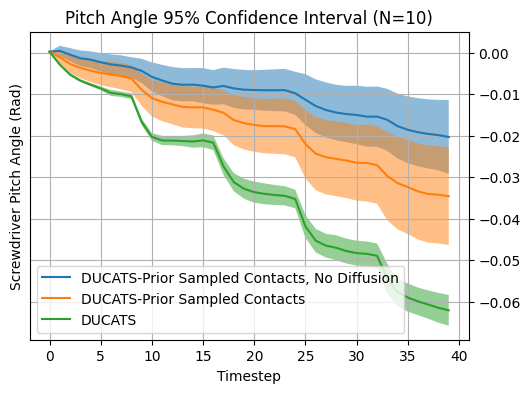

CSVTO + Diffusion + A* + replan no unc. propagation 5.0 -0.053161375 [-0.02904009 -0.04899066 -0.06455334 -0.05904897 -0.05759947 -0.03840619
 -0.03963365 -0.0714998  -0.07083797 -0.05200361]

CSVTO + Diffusion + A* + replan max likelihood 16 4.7 -0.047867574 [-0.05569692 -0.01815618 -0.04651945 -0.04164302 -0.05317747 -0.04219555
 -0.04957586 -0.04273747 -0.07097809 -0.05799573]

CSVTO + Diffusion + A* + replan 4.9 -0.062104166 [-0.07351802 -0.06021106 -0.0662703  -0.06703418 -0.06521438 -0.06037139
 -0.05052195 -0.06334452 -0.04891476 -0.06564108]



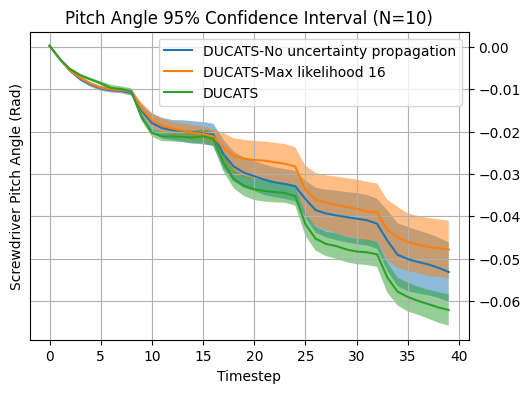

In [66]:
# keys_exec = ['fixed', 'planned w/ replanning', 'planned no replanning']
# keys_exec = ['CSVTO', 'Diffusion', 'Diffusion sc', 'CSVTO + Diffusion', 'CSVTO + Diffusion sc']
# keys_exec = ['CSVTO', 'Diffusion sc', 'CSVTO + Diffusion sc', 'CSVTO + Diffusion + A*', 'CSVTO + Diffusion + A* sc']

# keys_exec = ['CSVTO', 'CSVTO + Diffusion sc', 'CSVTO + Diffusion + A* sc', 'CSVTO + Diffusion + A* + replan sc']
stat = 'mean'
dofs_to_plot = ['pitch']

keys_exec = [
    'CSVTO',
    # 'Diffusion'
    'CSVTO + Diffusion',
     'CSVTO + Diffusion + A* + replan',
              ]
gen_plot_screwdriver_angle(data_exec_card, keys_exec, 'traj', dof_to_plot=dofs_to_plot, stat=stat, label_dict={
    'CSVTO': 'DUCATS-Prior Sampled Contacts, No Diffusion',
    # 'Diffusion': 'Diffusion',
    'CSVTO + Diffusion': 'DUCATS-Prior Sampled Contacts',
    # 'CSVTO + Diffusion + A* + replan': 'CSVTO + Diffusion + A*',
    'CSVTO + Diffusion + A* + replan': 'DUCATS',
})

keys_exec = [
              'CSVTO + Diffusion + A* + replan no unc. propagation',
              'CSVTO + Diffusion + A* + replan max likelihood 16',
            #   'CSVTO + Diffusion + A* + replan max likelihood',
                'CSVTO + Diffusion + A* + replan',
              ]
gen_plot_screwdriver_angle(data_exec_card, keys_exec, 'traj', dof_to_plot=dofs_to_plot, stat=stat, label_dict={
    # 'CSVTO + Diffusion + A* + replan': 'CSVTO + Diffusion + A*',
    'CSVTO + Diffusion + A* + replan': 'DUCATS',
    'CSVTO + Diffusion + A* + replan max likelihood 16': 'DUCATS-Max likelihood 16',
    # 'CSVTO + Diffusion + A* + replan max likelihood': 'DUCATS-Max likelihood 128',
    'CSVTO + Diffusion + A* + replan no unc. propagation': 'DUCATS-No uncertainty propagation'

})


In [ ]:
times = [
    [83.48350988898892, 73.09319564996986, 34.15417338802945, 107.31498918600846, 52.23775840597227, 68.03225325897802, 63.317319994966965, 80.92973514995538, 58.20432024402544, 79.72520893503679],
    [25.682552897022106, 39.1479274360463, 28.33342466596514, 39.43764162098523, 28.71264536702074, 34.76602611399721, 35.03842161502689, 22.985182866977993, 34.69330365897622, 34.44815740297781],
    [20.112224630021956, 50.53913740097778, 34.16484893200686, 40.01721888402244, 17.498814720020164, 22.99945097899763, 39.84765609697206, 39.85740367998369, 41.84802494995529, 40.08708220196422],
    [34.66240256599849, 22.882213937002234, 34.863087703997735, 22.681490924034733, 29.02524688997073, 22.40015482000308, 51.35696691699559],
    [17.42173602298135, 11.138173886982258, 16.714611278963275, 74.54060379997827],
    [22.858577820996288, 23.280934197013266],
    [5.559704903047532]
]

# Box plot for each list in times
fig, ax = plt.subplots()
ax.boxplot(times)

plt.title('Multi-Particle Planning Times')
# y axis label seconds
ax.set_ylabel('Planning time (Seconds)')
ax.set_xlabel('Contact mode iteration')
#y axis grid
ax.yaxis.grid(True)

In [ ]:
times = [
    [80.82100149901817],
    [],
    [],
    [],
    [],
    [],
    []
]

# Box plot for each list in times
fig, ax = plt.subplots()
ax.boxplot(times)

plt.title('No Uncertainty Propagation Planning Times')
# y axis label seconds
ax.set_ylabel('Planning time (Seconds)')
ax.set_xlabel('Contact mode iteration')

In [ ]:
def get_traj_init_only(name):
    path = f'/home/fanyang/github/ccai/data/experiments/{name}/csvgd'

    all_data = {}
    all_x = {}
    # all_d2goal = []
    all_traj_data = []

            
    constraint_violations_all = {
        # 'optimizer_paths': [],
        'traj': [],
        'inits': [],
        'plans': [],

    }
    plans_or_inits = 'inits'
    constraint_violations = constraint_violations_all['inits']

    traj_data=[None]*10
    for trial in tqdm(range(1, 11)):
        info_list = []
        if traj_data[trial-1] is None:
            try:
                with open(path + f'/trial_{trial}/contact_planning.pkl', 'rb') as f:
                    contact_node_sequence, closed_set, planning_time, expanded_nodes = pickle.load(f)
                    last_node = contact_node_sequence[-1]
                    data = last_node.trajectory
                    all_x[trial] = {'inits': data, 'planning_time': planning_time, 'expanded_nodes': expanded_nodes}
                    data = data.reshape(1, -1, 36)
            except:
                continue
        else:
            data = traj_data[trial-1]

        contact_sequence = np.array(last_node.contact_sequence)
        contact_sequence = (contact_sequence + 1)/2
        contact_sequence = [contact_sequence[i].sum() for i in range(contact_sequence.shape[0])]
        all_x[trial]['contact_sequence'] = contact_sequence

        for i in (range(len(contact_sequence))):
            c_state = contact_mode_dict[contact_sequence[i]]
            to_eval = data[:, i]
            # if plans_or_inits == 'optimizer_paths':
            #     to_eval = to_eval[0].flatten(0, 1)
            # info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
            if plans_or_inits in {'plans', 'inits', 'traj'}:
                info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
            else:
                to_eval = to_eval[0]
                all_infos = []
                for csvto_tstep in (range(data[t]['optimizer_paths'][i][0].shape[0])):
                    all_infos = calc_info(c_state, to_eval[csvto_tstep], all_infos, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
                info_list.append(all_infos)
        constraint_violations.append(info_list)

    # Take the list of dicts and turn it into a dict of lists
    all_data['violation'] = constraint_violations_all

    return all_x, all_data#, all_d2goal

In [ ]:
def get_traj_planned_init_only(name):
    path = f'/home/fanyang/github/ccai/data/experiments/{name}/csvgd'

    all_data = {}
    all_x = {}
    # all_d2goal = []
    all_traj_data = []

            
    constraint_violations_all = {
        # 'optimizer_paths': [],
        'traj': [],
        'inits': [],
        'plans': [],
        'planned_inits': [],

    }
    plans_or_inits = 'planned_inits'
    constraint_violations = constraint_violations_all[plans_or_inits]

    traj_data=[None]*10
    for trial in tqdm(range(1, 11)):
        info_list = []
        try:
            if traj_data[trial-1] is None:
                # try:
                with open(path + f'/trial_{trial}/contact_planning.pkl', 'rb') as f:
                    contact_node_sequence, closed_set, planning_time, expanded_nodes = pickle.load(f)
                    last_node = contact_node_sequence[-1]
                    data = last_node.trajectory
                    all_x[trial] = {'planned_inits': data, 'planning_time': planning_time, 'expanded_nodes': expanded_nodes, 'closed_set': closed_set}
                    print(data.shape)
                    data = data.reshape(1, -1, 16, 36)
                # except:
                #     print('failed')
                #     continue
            else:
                data = traj_data[trial-1]
        except:
            continue

        contact_sequence = np.array(last_node.contact_sequence)
        contact_sequence = (contact_sequence + 1)/2
        contact_sequence = [contact_sequence[i].sum() for i in range(contact_sequence.shape[0])]
        all_x[trial]['contact_sequence'] = contact_sequence
        
        for i in (range(len(contact_sequence))):
            c_state = contact_mode_dict[contact_sequence[i]]
            to_eval = data[:, i]
            # if plans_or_inits == 'optimizer_paths':
            #     to_eval = to_eval[0].flatten(0, 1)
            # info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
            if plans_or_inits in {'plans', 'inits', 'traj', 'planned_inits'}:
                info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
            else:
                to_eval = to_eval[0]
                all_infos = []
                for csvto_tstep in (range(data[t]['optimizer_paths'][i][0].shape[0])):
                    all_infos = calc_info(c_state, to_eval[csvto_tstep], all_infos, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
                info_list.append(all_infos)
        constraint_violations.append(info_list)

    # Take the list of dicts and turn it into a dict of lists
    all_data['violation'] = constraint_violations_all

    return all_x, all_data#, all_d2goal

In [ ]:
data = {}
for key, name in [
    # ('heuristic x1', 'allegro_screwdriver_diffusion_planned_initialization_lower_heuristic_bad_contact_map'),
    #               ('heuristic x10', 'allegro_screwdriver_diffusion_planned_initialization_low_heuristic_bad_contact_map'),
    #               ('heuristic x100', 'allegro_screwdriver_diffusion_planned_initialization_medium_heuristic_bad_contact_map'),
                  ('heuristic x1000 partial', 'allegro_screwdriver_diffusion_planned_initialization_partial_constraint_eval'),
                ('heuristic x1000 full', 'allegro_screwdriver_diffusion_planned_initialization_full_constraint_eval'),
                # ('heuristic x10000', 'allegro_screwdriver_diffusion_planned_initialization_higher_heuristic_bad_contact_map'),
                ]:
    data[key] = {}
    all_x, all_data = get_traj_planned_init_only(name)
    # data[key]['x'] = {
    #     'raw': all_x,
    #     'mean': np.mean(all_x, axis=0),
    #     'std': np.std(all_x, axis=0),
    # }
    data[key] = {**data[key], **all_data, **all_x}
    # data[key]['d2goal'] = {
    #     'raw': all_d2goal,
    #     'mean': np.mean(all_d2goal, axis=0),
    #     'std': np.std(all_d2goal, axis=0),
    # }

# with open('./saved_eval_inits_only.pkl', 'wb') as f:
#     pickle.dump(data, f)


In [ ]:
def gen_opt_path_violation_plot(data, keys):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    # violation_by_mode_g = {
    #     key: [] for key in keys
    # }

    # violation_by_mode_h = {
    #     key: [] for key in keys
    # }
    for key in keys:
        print(key)
        g_all = []

        constraint_violations = data[key]['violation']['optimizer_paths']
        # h_all = []
        for trial_ind in range(len(constraint_violations)):
            g_trial_ind = []
            # h_trial_ind = []
            for contact_mode_seq in constraint_violations[trial_ind]:
                opt_path_g = []
                for csvto_tstep in range(len(contact_mode_seq)):
                    g = torch.abs(contact_mode_seq[csvto_tstep]['g']).mean().cpu().item()
                    # h = torch.relu(contact_mode_seq['h']).mean().cpu().item()
                    opt_path_g.append(g)
                    # h_trial_ind.append(h)
                g_trial_ind.append(opt_path_g)
            g_all.append(g_trial_ind)
            # h_all.append(h_trial_ind)
        g_all = np.stack(g_all, axis=0).reshape(len(constraint_violations), -1)
        # h_all = np.stack(h_all, axis=0)
        g_all_mean = g_all.mean(axis=0)
        # h_all_mean = h_all.mean(axis=0)
        g_all_std = g_all.std(axis=0)
        # h_all_std = h_all.std(axis=0)
                # mode = contact_mode_seq['c_state']

                # violation_by_mode_g[mode].append(contact_mode_seq['g'])
                # violation_by_mode_h[mode].append(contact_mode_seq['h'])


        # plot g_all_mean with error bars
        ax.plot(g_all_mean, label=key)
        ax.fill_between(np.arange(g_all_mean.shape[0]), g_all_mean - g_all_std, g_all_mean + g_all_std, alpha=0.5)
    # ax.plot(h_all_mean, label='h_all_mean')
    # ax.fill_between(np.arange(h_all_mean.shape[0]), h_all_mean - h_all_std, h_all_mean + h_all_std, alpha=0.5)
    ax.legend()
    ax.set_xlabel('CSVTO Step')
    ax.set_ylabel('Constraint Violation')

    plt.title(f'Optimizer Path Constraint Violation (Contact and Kinematics)')
    plt.show()

In [ ]:
keys = ['rand_init_csvto', 'diff_init_csvto', 'proj_diff_init_csvto', 'diff_init_csvto_presampled']
gen_opt_path_violation_plot(data, keys)

In [ ]:
def gen_plot(constraint_violations_all, keys, plans_or_inits):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    for key in keys:
        plan_cv = constraint_violations_all[key]['violation'][plans_or_inits]
        if len(plan_cv) == 0:
            continue
        keys = ['pregrasp', 'index', 'thumb_middle', 'turn']
        # violation_by_mode_g = {
        #     key: [] for key in keys
        # }

        # violation_by_mode_h = {
        #     key: [] for key in keys
        # }
        g_all = []
        # h_all = []
        for trial_ind in range(len(plan_cv)):
            g_trial_ind = []
            # h_trial_ind = []
            for contact_mode_seq in plan_cv[trial_ind]:
                g = torch.abs(contact_mode_seq['g']).mean().cpu().item()
                # h = torch.relu(contact_mode_seq['h']).mean().cpu().item()
                g_trial_ind.append(g)
                # h_trial_ind.append(h)
            g_all.append(g_trial_ind)
            # h_all.append(h_trial_ind)
        # Find longest sequence in g_all
        max_len = max([len(x) for x in g_all])
        for i in range(len(g_all)):
            g_all[i] = g_all[i] + [0]*(max_len - len(g_all[i]))
        g_all = np.stack(g_all, axis=0)
        # h_all = np.stack(h_all, axis=0)
        g_all_mean = g_all.mean(axis=0)
        # h_all_mean = h_all.mean(axis=0)
        g_all_std = g_all.std(axis=0)
        # h_all_std = h_all.std(axis=0)
                # mode = contact_mode_seq['c_state']

                # violation_by_mode_g[mode].append(contact_mode_seq['g'])
                # violation_by_mode_h[mode].append(contact_mode_seq['h'])


        # plot g_all_mean with error bars
        ax.plot(g_all_mean, label=key)
        ax.fill_between(np.arange(g_all_mean.shape[0]), g_all_mean - g_all_std, g_all_mean + g_all_std, alpha=0.5)
    # ax.plot(h_all_mean, label='h_all_mean')
    # ax.fill_between(np.arange(h_all_mean.shape[0]), h_all_mean - h_all_std, h_all_mean + h_all_std, alpha=0.5)
    ax.legend()
    ax.set_xlabel('Contact Mode Index')
    ax.set_ylabel('Constraint Violation')

    plt.title(f'{plans_or_inits} Constraint Violation (Contact and Kinematics)')
    plt.show()
    # plt.savefig(f'/home/abhinav/Pictures/constraint_violation_analysis/{random_or_diffusion}_init_{key}.png')

    # 4 columns, 2 rows subplots
    # fig, axs = plt.subplots(2, 4, figsize=(12, 12))

    # for ind in range(4):
    #     key = keys[ind]
    #     print(violation_by_mode_g[key])
    #     this_mode_g = torch.abs(violation_by_mode_g[key][t])
    #     print(this_mode_g.shape)

    #     this_mode_h = torch.relu(violation_by_mode_h[key][t])
    #     print(this_mode_h.shape)

In [ ]:
keys = ['heuristic x1000 partial', 'heuristic x1000 full', 'pre-planned']

gen_plot(data, keys[-2:], 'planned_inits')

In [ ]:
keys = ['heuristic x1', 'heuristic x10', 'heuristic x100', 'heuristic x1000 partial', 'heuristic x1000 full']
gen_plot_screwdriver_angle(data, keys, 'planned_inits', dof_to_plot='roll')

In [ ]:
gen_plot_screwdriver_angle(data, keys, 'planned_inits', dof_to_plot='pitch')

In [ ]:
gen_plot_screwdriver_angle(data, keys, 'planned_inits', dof_to_plot='yaw')


In [ ]:
keys = [
    'heuristic x1',
 'heuristic x10',
 'heuristic x100',
 'heuristic x1000 full',
 'heuristic x10000']

In [ ]:
# Box and whisker plot plannning time by heuristic value
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
all_times = []
for key in keys:
    times = []
    for trial_ind in range(10):
        if trial_ind+1 in data[key]:
            times.append(data[key][trial_ind+1]['planning_time'])
    all_times.append(times)
labels = ['1', '10', '100', '1000', '10000']
ax.boxplot(all_times, labels=labels)
# Grid lines
ax.yaxis.grid(True)
ax.set_xlabel('Heuristic Multiplier')
ax.set_ylabel('Planning Time (s)')
plt.title('Planning Time by Heuristic Value (n=10)')

In [ ]:
import numpy as np
data = all_times[-1]
dat_mu = np.mean(data)
dat_sig = np.std(data)
from scipy import stats
interval = stats.norm.interval(.95, loc=dat_mu, scale=dat_sig/np.sqrt(len(data)))
mean = np.mean(interval)
pm = (interval[1] - interval[0])/2
print(f'95% CI: {mean} +/- {pm}')

In [ ]:
# Box and whisker plot expanded nodes by heuristic value
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
all_times = []
for key in keys:
    times = []
    for trial_ind in range(10):
        if trial_ind+1 in data[key]:
            times.append(data[key][trial_ind+1]['expanded_nodes'])
    all_times.append(times)
# Color each boxplot differently
ax.boxplot(all_times, labels=keys)
# Grid lines
ax.yaxis.grid(True)
ax.set_xlabel('Heuristic Multiplier')
ax.set_ylabel('Expanded Nodes')
plt.title('Expanded Nodes by Heuristic Value (n=10)')

In [ ]:
contact_label_to_vec = {'pregrasp': 0,
                        'index': 2,
                        'thumb_middle': 1,
                        'turn': 3
                        }
contact_vec_to_label = dict((v, k) for k, v in contact_label_to_vec.items())

def get_yaw_change(data, key):
    yaw_change_by_mode = {
        'pregrasp': [],
        'index': [],
        'thumb_middle': [],
        'turn': []
    }
    for trial_ind in range(10):    
        closed_set = list(data[key][trial_ind + 1]['closed_set'])
        for node in closed_set:
            traj = node.trajectory
            if traj.shape[0] > 16:
                ending_yaw = traj[-1, 14]
                prev_segment_ending_yaw = traj[-17, 14]
            else:
                continue

            contact_mode = np.array(node.contact_sequence[-1])
            contact_mode = (contact_mode + 1)/2
            contact_mode = contact_vec_to_label[int(sum(contact_mode))]
            yaw_change = (ending_yaw - prev_segment_ending_yaw).item()
            yaw_change_by_mode[contact_mode].append(yaw_change)
    # Box plot yaw change by contact mode and bar plot mean yaw change by contact mode with error bars
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    ax[0].boxplot(yaw_change_by_mode.values(), labels=yaw_change_by_mode.keys())
    ax[0].set_xlabel('Contact Mode')
    ax[0].set_ylabel('Yaw Change (rad)')
    ax[0].set_title('Yaw Change by Contact Mode')
    ax[0].yaxis.grid(True)

    ax[1].bar(yaw_change_by_mode.keys(), [np.mean(yaw_change_by_mode[key]) for key in yaw_change_by_mode.keys()])
    ax[1].errorbar(yaw_change_by_mode.keys(), [np.mean(yaw_change_by_mode[key]) for key in yaw_change_by_mode.keys()], [np.std(yaw_change_by_mode[key]) for key in yaw_change_by_mode.keys()], linestyle='none')
    ax[1].set_xlabel('Contact Mode')
    ax[1].set_ylabel('Yaw Change (rad)')
    ax[1].set_title('Yaw Change by Contact Mode')
    ax[1].yaxis.grid(True)
    # Black line y = 0
    ax[1].axhline(0, color='black')
    plt.show()

In [ ]:
get_yaw_change(data, 'heuristic x1')

In [ ]:
get_yaw_change(data, 'heuristic x10')

In [ ]:
get_yaw_change(data, 'heuristic x100')

In [ ]:
get_yaw_change(data, 'heuristic x1000')

In [ ]:
get_yaw_change(data, 'heuristic x10000')

In [ ]:
contact_label_to_vec = {'pregrasp': 0,
                        'index': 2,
                        'thumb_middle': 1,
                        'turn': 3
                        }
contact_vec_to_label = dict((v, k) for k, v in contact_label_to_vec.items())

def get_yaw_change_exec(data, data_contact, key):
    yaw_change_by_mode = {
        'pregrasp': [],
        'index': [],
        'thumb_middle': [],
        'turn': []
    }
    for trial_ind in range(10):
        traj = data[key][t][trial_ind]['traj'].reshape(-1, t, 36)[:, :15]
        for t in range(1, traj.shape[0]):
            ending_yaw = traj[t, -1, 14]
            prev_segment_ending_yaw = traj[t-1, -1, 14]
            
            contact_sequence = data_contact[key][trial_ind+1]['contact_sequence']
            contact_mode = contact_vec_to_label[int(contact_sequence[t])]
            yaw_change = (ending_yaw - prev_segment_ending_yaw).item()
            yaw_change_by_mode[contact_mode].append(yaw_change)
    # Box plot yaw change by contact mode and bar plot mean yaw change by contact mode with error bars
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    ax[0].boxplot(yaw_change_by_mode.values(), labels=yaw_change_by_mode.keys())
    ax[0].set_xlabel('Contact Mode')
    ax[0].set_ylabel('Yaw Change (rad)')
    ax[0].set_title('Yaw Change by Contact Mode')
    ax[0].yaxis.grid(True)

    ax[1].bar(yaw_change_by_mode.keys(), [np.mean(yaw_change_by_mode[key]) for key in yaw_change_by_mode.keys()])
    ax[1].errorbar(yaw_change_by_mode.keys(), [np.mean(yaw_change_by_mode[key]) for key in yaw_change_by_mode.keys()], [np.std(yaw_change_by_mode[key]) for key in yaw_change_by_mode.keys()], linestyle='none')
    ax[1].set_xlabel('Contact Mode')
    ax[1].set_ylabel('Yaw Change (rad)')
    ax[1].set_title('Yaw Change by Contact Mode')
    ax[1].yaxis.grid(True)
    # Black line y = 0
    ax[1].axhline(0, color='black')
    plt.show()

In [ ]:
get_yaw_change_exec(data_exec, data, 'heuristic x1')

In [ ]:
get_yaw_change_exec(data_exec, data, 'heuristic x10')

In [ ]:
get_yaw_change_exec(data_exec, data, 'heuristic x100')

In [ ]:
get_yaw_change_exec(data_exec, data, 'heuristic x1000')

In [ ]:
get_yaw_change_exec(data_exec, data, 'heuristic x10000')

In [ ]:
data.keys()

In [ ]:
data_exec['pre-planned'][t][0].keys()

In [ ]:
def violation_histogram(data, key):
    g_violation_by_c_state = {
        'pregrasp': [],
        'index': [],
        'thumb_middle': [],
        'turn': []
    }
    h_violation_by_c_state = {
        'pregrasp': [],
        'index': [],
        'thumb_middle': [],
        'turn': []
    }
    full_violation_by_c_state = {
        'pregrasp': [],
        'index': [],
        'thumb_middle': [],
        'turn': []
    }

    for trial_ind in range(len(data[key]['violation']['planned_inits'])):
        for c_ind, contact_mode in enumerate(data[key]['violation']['planned_inits'][trial_ind]):
            c_state = contact_mode['c_state']
            g = torch.abs(contact_mode['g']).sum().cpu().item()
            g_violation_by_c_state[c_state].append(g)
            full = g
            if contact_mode['h'] is not None:
                h = torch.relu(contact_mode['h']).sum().cpu().item()
                h_violation_by_c_state[c_state].append(h)
                full += h
            full_violation_by_c_state[c_state].append(full)
            if full > .02 and c_state != 'turn':
                print(f'Violation: {full}, Contact Mode: {c_state}, Trial: {trial_ind+1}, Contact Mode Index: {c_ind}')
    # Histogram of constraint violation by contact mode (3 rows, 4 columns)

    fig, axs = plt.subplots(3, 4, figsize=(12, 12))
    for i, c_state in enumerate(g_violation_by_c_state.keys()):
        axs[0, i].hist(g_violation_by_c_state[c_state])
        axs[0, i].set_title(f'{c_state} g')
        axs[1, i].hist(h_violation_by_c_state[c_state])
        axs[1, i].set_title(f'{c_state} h')
        axs[2, i].hist(full_violation_by_c_state[c_state])
        axs[2, i].set_title(f'{c_state} full')
    plt.show()
    return g_violation_by_c_state, h_violation_by_c_state, full_violation_by_c_state


In [ ]:
g_violation_by_c_state_full, h_violation_by_c_state_full, full_violation_by_c_state_full = violation_histogram(data, 'heuristic x1000 full')

In [ ]:
g_violation_by_c_state_partial, h_violation_by_c_state_partial, full_violation_by_c_state_partial = violation_histogram(data, 'heuristic x1000 partial')